# Airbnb in Seattle

The goal of this notebook is to analyze Airbnb data in Seattle. The analysis will be centered around 4 questions:
1. What influences the price of Airbnb listings?
2. Which amenities contributes the most to increase a listing rating?
3. What makes a host a superhost?
4. When is the busiest period in Seattle, based on houses availability? Are the prices following the trend?

## Import packages and data
Let's first import the python packages and data into the notebook.

In [698]:
# Import packages
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import display
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV


from IPython.display import display
pd.options.display.max_columns = None

# Import data
listings = pd.read_csv('./listings.csv')
calendar = pd.read_csv('./calendar.csv')

## Preview listings data
Let's see how the listings data looks like.

In [428]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

## Clean the data
Let's now clean the dataset to get it ready for analysis.

### Let's first check how many columns have missing values

In [489]:
# Get the list of columns with missing values and their proportion of missing values

def missing_values(data):

    missing_values = pd.DataFrame((len(data)-data.count())/len(data)*100).reset_index()
    missing_values.columns = ['field', 'count_nulls']
    return missing_values[missing_values['count_nulls']>0].sort_values('count_nulls',ascending=False)

missing_values(listings)

,field,count_nulls
84,license,100.000000
56,square_feet,97.459403
59,monthly_price,60.267156
60,security_deposit,51.126244
58,weekly_price,47.380828
10,notes,42.063908
9,neighborhood_overview,27.029859
61,cleaning_fee,26.977475
11,transit,24.463070
21,host_about,22.498690


### Basic data cleaning
I will first do basic cleaning operations such as: removing data will all missing values, removing columns with only one value, set the fields to the right data type, create dummy variables for categorical variables, removing columns with no value for analysis,...

In [429]:
# Get the inputs to clean the data

columns_no_value = ['id','listing_url','thumbnail_url','medium_url','picture_url'
                    ,'xl_picture_url','host_id','host_url','host_thumbnail_url'
                    ,'host_picture_url','latitude','longitude','host_name'
                    ,'neighbourhood','state','street', 'city','zipcode', 'smart_location'
                    ,'calendar_updated', 'first_review', 'last_review', 'neighbourhood_cleansed'
                    ,'host_verifications', 'monthly_price', 'weekly_price']

price_columns = ['price','security_deposit','cleaning_fee','extra_people']

percentages_columns = ['host_response_rate','host_acceptance_rate']

text_columns = ['name','summary','space','description','neighborhood_overview','notes','transit'
                ,'host_about','host_location','host_neighbourhood']

dummies_columns = ['host_response_time','neighbourhood_group_cleansed','property_type','room_type'
                   ,'bed_type','cancellation_policy']

In [430]:
# Create a function that will clean the data

def clean_listings_data(data, missing_threshold, columns_no_value, price_columns, percentages_columns
                        , remove_text_columns, text_columns, dummies_columns):
    
    # Remove columns with missing values only
    data = data.dropna(axis=1, how='all')
    
    # Remove columns with 90% missing values
    # The other columns with missing values will be handeled later, depending on which question we want to answer
    missing_values_only = list(data.columns[data.isnull().mean() >= missing_threshold])
    data = data.drop(list(missing_values_only),axis=1)
    
    # Remove columns with the same value
    nunique = data.apply(pd.Series.nunique)
    cols_same_value = nunique[nunique == 1].index
    data = data.drop(list(cols_same_value),axis=1)
    
    # Remove columns with no value for the analysis
    data = data.drop(columns_no_value, axis=1)
    
    # Remove text columns if needed
    if remove_text_columns == True:
        data = data.drop(text_columns, axis=1)
    
    # Remove $ and commas from price-related fields
    for col in price_columns:
        data[col] = data[col].str.slice(start=1).astype(str).str.replace(",","").astype(float)
        
    # Remove % sign from percentage-related fields
    for col in percentages_columns:
        data[col] = data[col].str.strip('%').astype(float)/100
        
    # Change t/f columns to boolean types
    for col in data.columns:
        if list(data[col].dropna().unique()) == ['f', 't'] or list(data[col].dropna().unique()) == ['t', 'f']:
            data[col] = data[col].replace('t',1).replace('f',0)
            
    # Create dummy variables for categorical variables suited for dummy
    # We are keeping the categorical columns on purpose for further data exploration
    for col in dummies_columns:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col 
                 , prefix_sep='_', drop_first=False, dummy_na = False)], axis=1)
    
    return data

In [431]:
# Get a cleaned dataset
listings_clean = clean_listings_data(listings, 0.9, columns_no_value, price_columns, percentages_columns
                                     , True, text_columns, dummies_columns)

# Preview the cleaned dataset
listings_clean.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,2011-08-11,within a few hours,0.96,1.0,0.0,3.0,3.0,1.0,1.0,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,NaN,NaN,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,2013-02-21,within an hour,0.98,1.0,1.0,6.0,6.0,1.0,1.0,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,2014-06-12,within a few hours,0.67,1.0,0.0,2.0,2.0,1.0,1.0,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,2013-11-06,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,Queen Anne,1,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,NaN,NaN,1,0.0,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
4,2011-11-29,within an hour,1.00,NaN,0.0,2.0,2.0,1.0,1.0,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

### Create new fields
Let's create new fields based on the existing ones that will be better suited for analysis.

In [432]:
# Convert the 'host_since' columns into days since host 

def host_since_into_days(data, column_in, column_out):
    # Calculate the number of days since host
    today = date.today()
    days_since_host = today - pd.to_datetime(data[column_in])

    # Convert into days
    days_host = []
    for row in days_since_host:
        row = row.days
        days_host.append(row)

    # Create days since host column 
    data[column_out] = pd.Series(days_host)

    # Drop host since column
    data = data.drop(column_in,axis=1)
    
    return data
    
listings_clean = host_since_into_days(listings_clean, 'host_since', 'days_since_host')

In [433]:
# Create a column for each amenity

def column_each_amenity(data, amenity_column):

    # Convert amenity field values into lists
    cleaned_amenities = data[amenity_column].str.strip('{').str.strip('}').str.replace('"',"").str.lower()

    for item in range(0,len(cleaned_amenities)):
        cleaned_amenities[item] = cleaned_amenities[item].split(",")
    
    # Create a new dataframe with one column per amenity
    amenity_df = cleaned_amenities.apply(frozenset).to_frame(name='amenity')

    for amenity in frozenset.union(*amenity_df.amenity):
        amenity_df[amenity] = amenity_df.apply(lambda _: int(amenity in _.amenity), axis=1)

    # Drop not useful columns
    # amenity = list with all the amenities
    # washer / dryer = there are no instances where this value is 1 and washer = 0 or dryer = 0
    amenity_df = amenity_df.drop(['amenity','washer / dryer'],axis=1)

    # Drop amenity column from initial dataset
    data = data.drop(amenity_column,axis=1)

    # Concatenate dataframes
    data = pd.concat([data, amenity_df], axis=1)
    
    return data, amenity_df

listings_clean, amenity_df = column_each_amenity(listings_clean, 'amenities')

In [434]:
listings_clean.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,days_since_host,carbon monoxide detector,,24-hour check-in,suitable for events,smoking allowed,shampoo,hangers,heating,pool,cable tv,other pet(s),buzzer/wireless intercom,hair dryer,washer,pets allowed,free parking on premises,safety card,iron,laptop friendly workspace,elevator in building,indoor fireplace,tv,wheelchair accessible,hot tub,fire extinguisher,air conditioning,smoke detector,lock on bedroom door,first aid kit,essentials,wireless internet,pets live on this property,cat(s),breakfast,family/kid friendly,kitchen,gym,dryer,internet,dog(s),doorman
0,within a few hours,0.96,1.0,0.0,3.0,3.0,1.0,1.0,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,NaN,NaN,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,2894.0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0
1,within an hour,0.98,1.0,1.0,6.0,6.0,1.0,1.0,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,2334.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0,0
2,within a few hours,0.67,1.0,0.0,2.0,2.0,1.0,1.0,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,975.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1858.0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,0,1,1,1,0
3,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,Queen Anne,1,Apart

## Find insights
I will now take every question and analyze the data related to them. I will also model the data to find insights within the data.

###  0. Distribution of listings
Let's first have a look at the data in general and how the listings are spread.

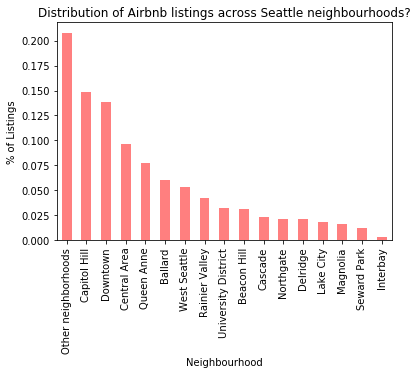

In [435]:
# How are the listings spread accross neighbourhoods groups?

def plot_distribution(data, variable, title, xlabel, ylabel):
    
    groups = data[variable].value_counts()
    (groups/data.shape[0]).plot(kind="bar",color=(1, 0, 0, 0.5));
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plot_distribution(listings_clean, 'neighbourhood_group_cleansed',"Distribution of Airbnb listings across Seattle neighbourhoods?"
                 ,'Neighbourhood', '% of Listings')

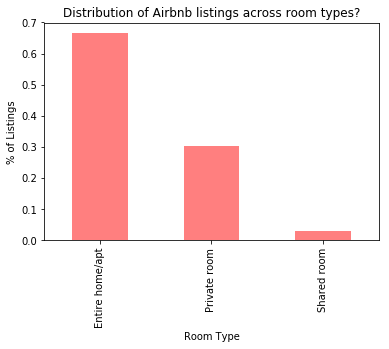

In [436]:
# What are the most popular room types in Seattle?

plot_distribution(listings_clean, 'room_type',"Distribution of Airbnb listings across room types?"
                 ,'Room Type', '% of Listings')

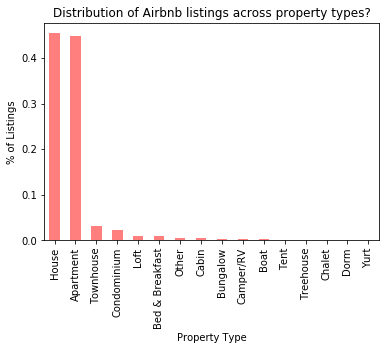

In [437]:
# What are the most popular property types in Seattle?

plot_distribution(listings_clean, 'property_type',"Distribution of Airbnb listings across property types?"
                 ,'Property Type', '% of Listings')

### 1. What influences the price of Airbnb listings?
Let's now analyze and model what factors influence the price of the Airbnb listings in Seattle.

**Let's first vizualize the average price according to different dimensions.**

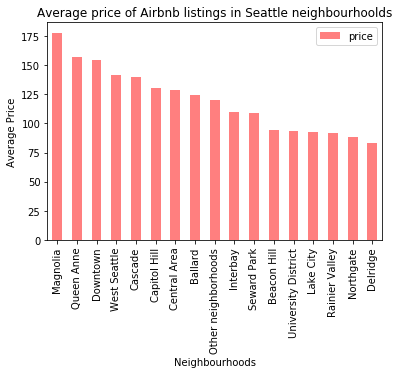

In [438]:
# What is the average price accross neighbourhoods?

def plot_distribution_average(data, variable, average_variable, title, xlabel, ylabel):
    
    averages = pd.DataFrame(data.groupby([variable]).mean()[average_variable])
    averages_sorted = averages.sort_values(average_variable, ascending=False)
    averages_sorted.plot(kind="bar",color=(1, 0, 0, 0.5));
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
plot_distribution_average(listings_clean, 'neighbourhood_group_cleansed','price' 
                         ,"Average price of Airbnb listings in Seattle neighbourhoolds",'Neighbourhoods', 'Average Price')

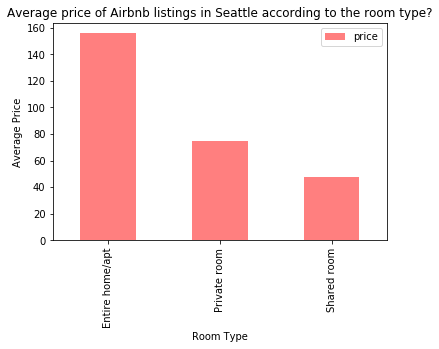

In [439]:
# What is the average price accross room types?

plot_distribution_average(listings_clean, 'room_type','price' 
                         ,"Average price of Airbnb listings in Seattle according to the room type?"
                         ,'Room Type', 'Average Price')

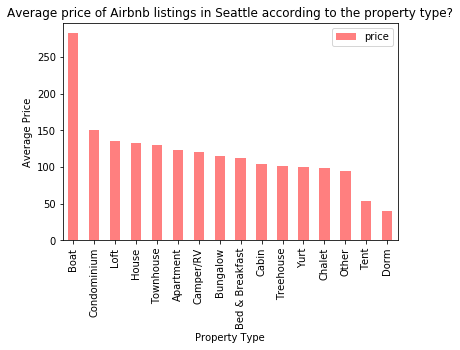

In [440]:
# What is the average price accross property types?

plot_distribution_average(listings_clean, 'property_type','price' 
                         ,"Average price of Airbnb listings in Seattle according to the property type?"
                         ,'Property Type', 'Average Price')

**Let's now drop the categorical variables that can't be used to model the data**

In [498]:
listings_q1 = listings_clean.drop(listings_clean.select_dtypes(include=['object']).columns, axis=1)

**Let's drop the columns that we do not want to include in the analysis.**

These are the columns that we do not believe will give us much insights about what influences the prices.

In [499]:
columns_to_drop = ['reviews_per_month','host_total_listings_count','guests_included','require_guest_profile_picture'
                 ,'require_guest_phone_verification','calculated_host_listings_count','host_response_time_a few days or more'
                 ,'host_response_time_within a day','host_response_time_within a few hours','host_response_time_within an hour']

listings_q1 = listings_q1.drop(columns_to_drop, axis=1)

**Let's modify some columns if we need to**

*Extra people*

The amount to pay for extra guests will be considered as high or low depending on the initial price of the listing. Therefore, we will modify the column to express it as a proportion of the price.

In [500]:
listings_q1['extra_people'] = listings_q1['extra_people']/listings_q1['price']

*Security deposit and cleaning fee*

I will first look at security deposit and cleaning fee. After screening multiple houses on airbnb website, I dicovered that there aren't always security deposits and cleaning fees asked for a listing. I will assume then when the value is null for this column it means that there is no security deposit or cleaning fee.

However, it is difficult to work with these as a number because they are fixed, independently of the length of the stay. For example, if the cleaning fee is 20 dollars, a person who only stays one day will pay 20 dollars per day for the cleaning fees. However, if a person stays 5 days, the person will pay 4 dollars per day for the fee.

To handle this complexity, I will create new fields for security deposit and cleaning fees that will only indicate if there is one.

In [501]:
fields_to_modify = ['security_deposit','cleaning_fee']

for field in fields_to_modify:
    listings_q1[field] = np.where(listings_q1[field] > 0, 1, 0)

**Let's look at the remaining columns with missing values and decide whether I want to**
1. keep them in the analysis or not
2. fill them with 0
3. fill them with the mean
4. fill them with another number
5. create a new field based on the column with missing values

In [502]:
missing_values(listings_q1)

,field,count_nulls
1,host_acceptance_rate,20.246202
25,review_scores_checkin,17.234154
23,review_scores_accuracy,17.234154
28,review_scores_value,17.181771
27,review_scores_location,17.155579
24,review_scores_cleanliness,17.103195
26,review_scores_communication,17.050812
22,review_scores_rating,16.946045
0,host_response_rate,13.698271
8,bathrooms,0.419068


*Host acceptance rate and host reponse rate*

The host acceptance rate and host response rate may not be provided in certain cases. We will first check if those values are correlated with other ones to be able to fill them.

In [503]:
def correlation_feature(data, feature):
    return pd.DataFrame(data.corr()[feature]).abs().sort_values(feature, ascending=False)
    
correlation_feature(listings_q1,'host_acceptance_rate').head(10)

,host_acceptance_rate
host_acceptance_rate,1.000000
bed_type_Pull-out Sofa,0.155144
room_type_Shared room,0.095439
bed_type_Real Bed,0.089876
smoke detector,0.046079
neighbourhood_group_cleansed_Capitol Hill,0.043869
buzzer/wireless intercom,0.043696
instant_bookable,0.039126
host_identity_verified,0.038433
air conditioning,0.037850


In [504]:
correlation_feature(listings_q1,'host_response_rate').head(10)

,host_response_rate
host_response_rate,1.000000
review_scores_cleanliness,0.170897
review_scores_rating,0.156567
review_scores_communication,0.155346
host_is_superhost,0.153810
review_scores_value,0.149482
review_scores_checkin,0.148516
hair dryer,0.134133
fire extinguisher,0.132808
review_scores_accuracy,0.130925


There isn't an strong correlation between host acceptance rate/host response rate and another column. Given that the data is missing in 20% and 13% of the cases respectively, we prefer to drop those two columns. Indeed, filling the data mean the mean would be too subjective.

In [505]:
listings_q1 = listings_q1.drop(['host_acceptance_rate','host_response_rate'], axis = 1)

*Review scores*

For this exercise, we will only focus on the main review score. Therefore, we will drop all the other components of the review score rating.

In [506]:
review_columns_to_drop = ['review_scores_accuracy','review_scores_checkin','review_scores_value','review_scores_location'
                          ,'review_scores_cleanliness','review_scores_communication']

listings_q1 = listings_q1.drop(review_columns_to_drop,axis=1)

Moreover, 16% of the listings do not have any reviews, and therefore do not have any rating. Let's see if the rating is strongly correlated to another variable. Otherwise, we will fill the values with the column mean.

In [507]:
correlation_feature(listings_q1,'review_scores_rating').head(10)

,review_scores_rating
review_scores_rating,1.000000
host_is_superhost,0.240895
neighbourhood_group_cleansed_University District,0.163227
shampoo,0.131519
fire extinguisher,0.117084
first aid kit,0.114217
host_listings_count,0.109357
safety card,0.105639
carbon monoxide detector,0.101819
pets live on this property,0.092559


In [508]:
listings_q1['review_scores_rating'] = listings_q1['review_scores_rating'].fillna(listings_q1['review_scores_rating'].mean())

*Others*

We will fillt the other values with the mean. These are either the host_response_rate or values with less than 1% of missing values.

In [509]:
# Columns with still missing values
missing_values_cols = list(listings_q1.columns[listings_q1.isnull().mean() > 0])

# Fill with the mean
for col in missing_values_cols:
    listings_q1[col] = listings_q1[col].fillna(listings_q1[col].mean())

In [510]:
listings_q1.head()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,instant_bookable,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,days_since_host,carbon monoxide detector,,24-hour check-in,suitable for events,smoking allowed,shampoo,hangers,heating,pool,cable tv,other pet(s),buzzer/wireless intercom,hair dryer,washer,pets allowed,free parking on premises,safety card,iron,laptop friendly workspace,elevator in building,indoor fireplace,tv,wheelchair accessible,hot tub,fire extinguisher,air conditioning,smoke detector,lock on bedroom door,first aid kit,essentials,wireless internet,pets live on this property,cat(s),breakfast,family/kid friendly,kitchen,gym,dryer,internet,dog(s),doorman
0,0.0,3.0,1.0,1.0,1,4,1.0,1.0,1.0,85.0,0,0,0.058824,1,365,14,41,71,346,207,95.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,2894.0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0
1,1.0,6.0,1.0,1.0,1,4,1.0,1.0,1.0,150.0,1,1,0.000000,2,90,13,13,16,291,43,96.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,2334.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0,0
2,0.0,2.0,1.0,1.0,1,11,4.5,5.0,7.0,975.0,1,1,0.025641,4,30,1,6,17,220,20,97.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1858.0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,0,1,1,1,0
3,0.0,1.0,1.0,1.0,1,3,1.0,0.0,2.0,100.0,0,0,0.000000,1,1125,0,0,0,143,0,94.539262,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,2076.0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,1,0,0
4,0.0,2.0,1.0,1.0,1,6,2.0,3.0,3.0,450.0,1,1,0.033333,1,1125,30,60,90,365,38,92.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,2784.0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,0


**Let's look at the correlation between the features and the price**

Let's look at the top 25 correlated features. That will help us determine which features we should keep into our model.

In [525]:
correlation_feature(listings_q1,'price').head(25)

,price
price,1.000000
accommodates,0.652218
bedrooms,0.627596
beds,0.589306
bathrooms,0.516017
room_type_Entire home/apt,0.435622
room_type_Private room,0.387502
family/kid friendly,0.259901
cable tv,0.237309
cancellation_policy_strict,0.226632


Obvisouly, there are too many features in the data. We need to reduce the number of features to improve our model's accuracy. To do so, we will remove all the features that have less than 5% correlation (in absolute value) with the price (see in the next function).

**Let's run a linear regression on our data to see what influences the price the most**

In [512]:
def get_linear_regression_score(data, independent_var, test_size, random_state, percentage_correlation):
    
    # Remove features with less than x% correlation
    correlation = correlation_feature(data,independent_var).reset_index()
    correlation.columns = ['column', 'correlation']
    correlation_less_than_x = list(correlation[correlation['correlation'] <= percentage_correlation]['column'])
    data = data.drop(correlation_less_than_x, axis = 1)
    
    # Get X and y
    X = data.drop(independent_var,axis=1)
    y = data[independent_var]

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state) 

    # Instantiate and fit the model
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    # Get the coefficients
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
    return test_score, train_score, coefs_df

In [513]:
q1_test_score, q1_train_score, coefs_df_q1 = get_linear_regression_score(listings_q1, 'price', 0.30, 42, 0.05)
q1_test_score

0.58632376993558077

In [514]:
coefs_df_q1.sort_values('abs_coefs', ascending=False).head(20)

,est_int,coefs,abs_coefs
30,cancellation_policy_moderate,-1.856046e+14,1.856046e+14
29,cancellation_policy_flexible,-1.856046e+14,1.856046e+14
31,cancellation_policy_strict,-1.856046e+14,1.856046e+14
24,room_type_Shared room,-6.550613e+13,6.550613e+13
23,room_type_Private room,-6.550613e+13,6.550613e+13
22,room_type_Entire home/apt,-6.550613e+13,6.550613e+13
21,property_type_Boat,1.315291e+02,1.315291e+02
7,extra_people,-3.959573e+01,3.959573e+01
16,neighbourhood_group_cleansed_Northgate,-3.431633e+01,3.431633e+01
57,doorman,2.976349e+01,2.976349e+01


### 2. Which amenities contributes the most to increase a listing rating?

**Let's keep only the main rating and amenities fields**

In [515]:
ratings_amenities = pd.concat([listings_clean['review_scores_rating'], amenity_df.drop("",axis=1)], axis=1)

**Let's handle the remaining missing values**

In [516]:
# Which columns have missing values and in which proportion
missing_values(ratings_amenities)

,field,count_nulls
0,review_scores_rating,16.946045


In [517]:
# Remove rows without a rating, given that it is the independent variable we want to look at
ratings_amenities = ratings_amenities.dropna(subset=['review_scores_rating'], how='any')

In [518]:
ratings_amenities.head()

,review_scores_rating,carbon monoxide detector,24-hour check-in,suitable for events,smoking allowed,shampoo,hangers,heating,pool,cable tv,other pet(s),buzzer/wireless intercom,hair dryer,washer,pets allowed,free parking on premises,safety card,iron,laptop friendly workspace,elevator in building,indoor fireplace,tv,wheelchair accessible,hot tub,fire extinguisher,air conditioning,smoke detector,lock on bedroom door,first aid kit,essentials,wireless internet,pets live on this property,cat(s),breakfast,family/kid friendly,kitchen,gym,dryer,internet,dog(s),doorman
0,95.0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0
1,96.0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0,0
2,97.0,1,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,0,1,1,1,0
4,92.0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,0
5,95.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0


**Let's do some exploratory analysis on the data**

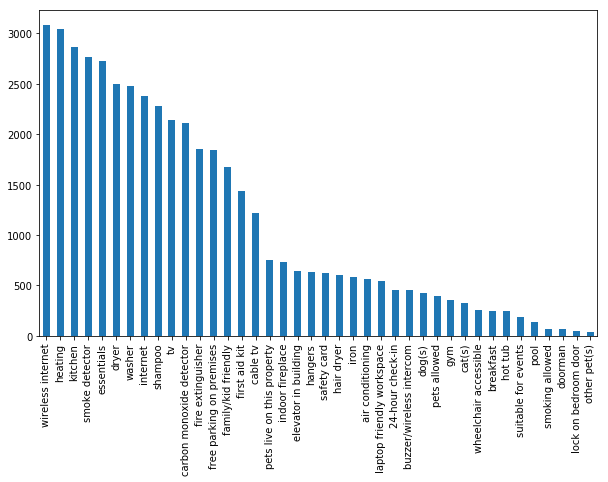

In [519]:
# What is the proportion of listings that have each amenity?
ratings_amenities.drop('review_scores_rating', axis=1).sum(axis = 0, skipna = False).sort_values(ascending = False).plot(kind="bar",figsize=(10, 6))

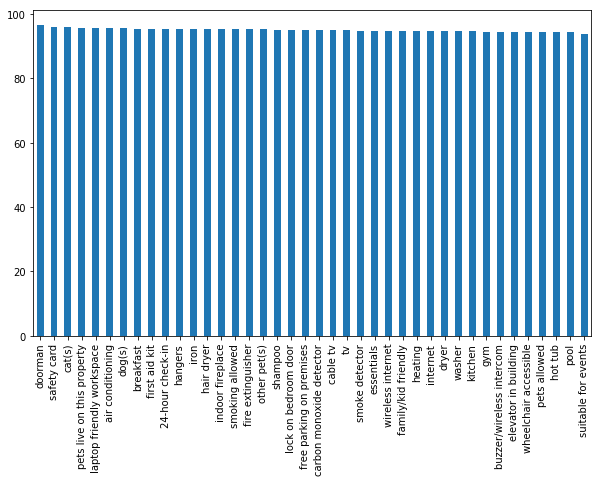

In [520]:
# What is the average rating per listing that has the amenity?
mean_list = []

for amenity in list(ratings_amenities.drop('review_scores_rating',axis=1).columns):
    mean = ratings_amenities['review_scores_rating'][ratings_amenities[amenity] == 1].mean()
    mean_list.append(mean)
    
amenity_ranking_mean = pd.Series(mean_list, index=list(ratings_amenities.drop('review_scores_rating',axis=1).columns))
amenity_ranking_mean.sort_values(ascending = False).plot(kind="bar",figsize=(10, 6))

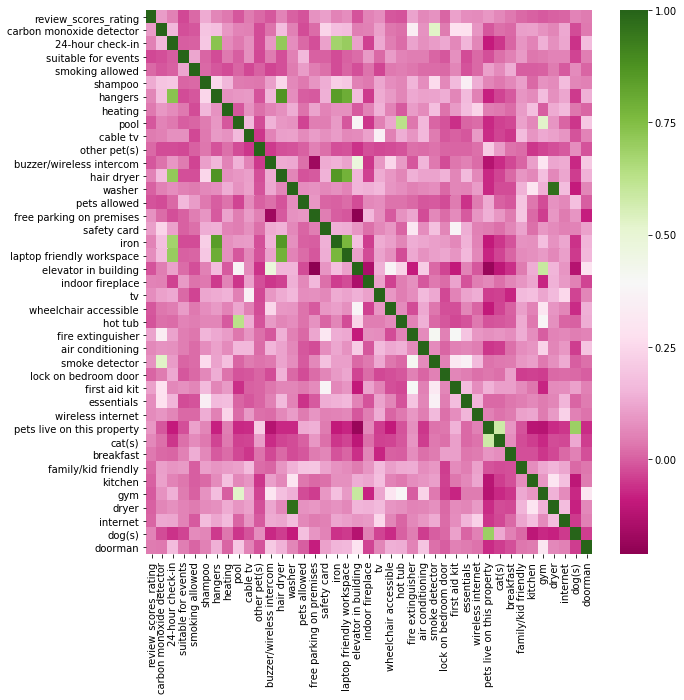

In [522]:
# Let's look at the correlation matrix between all the values
def corr_matrix(data, size):
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(data.corr(), ax = ax, cmap = 'PiYG')
    
corr_matrix(ratings_amenities, (10,10))

In [523]:
# Let's look at the top 10 variables the most correlated with the ratings
correlation_feature(ratings_amenities,'review_scores_rating').head(10)

,review_scores_rating
review_scores_rating,1.000000
shampoo,0.131519
fire extinguisher,0.117084
first aid kit,0.114217
safety card,0.105639
carbon monoxide detector,0.101819
pets live on this property,0.092559
free parking on premises,0.085832
smoke detector,0.083738
tv,0.075520


**Let's run a linear regression to find out what influences the rating the most**

In [524]:
q2_test_score, q2_train_score, coefs_df = get_linear_regression_score(ratings_amenities, 'review_scores_rating', 0.30, 42, 0.05)
q2_test_score

0.02519772480395821

We can see that the model does not explain well the rating. Therefore, we can conclude that there isn't an amenity which has an influence on the rating.

### 3. What makes a host a superhost?

### 4. When is the busiest period in Seattle, based on houses availability? Are the prices following the trend?

For this question, we will look at the calendar data instead of the listings data.

In [526]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


**Clean the data**

In [699]:
def clean_calendar_data(data, date_column, price_column, columns_no_need):
      
    # Convert dates columns from object to date
    data['date_available'] = pd.to_datetime(data[date_column])
    
    # Remove $ from price (price always filled except when non available)
    data[price_column] = data[price_column].fillna('$0').str.slice(start=1).str.replace(",","").astype(float)
    
    # Keep available dates only
    data = data[data['available'] == 't']  
    
    # Drop columns with do not need
    data_clean = data.drop(columns_no_need, axis=1)
    
    return data_clean

In [700]:
calendar_clean = clean_calendar_data(calendar, 'date', 'price', ['listing_id', 'available', 'date'])
calendar_clean.head()

,price,date_available
0,85.0,2016-01-04
1,85.0,2016-01-05
9,85.0,2016-01-13
10,85.0,2016-01-14
14,85.0,2016-01-18


**Plot the data**

Let's look at the distribution of the available listings and their average prices.

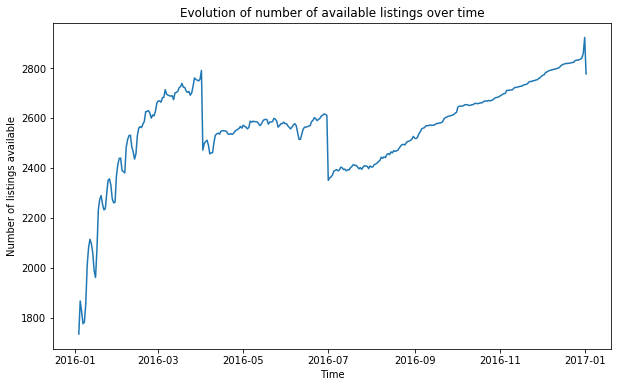

In [701]:
## Look at the availability distribution

def plot_nb_listings(data, xaxis, yaxis, title, xlabel, ylabel):
    
    listings_per_day = data.groupby(xaxis).count().reset_index()
    listings_per_day.columns = [xaxis,yaxis]
    x_listings = listings_per_day[xaxis]
    y_listings = listings_per_day[yaxis]
    plt.figure(figsize=(10,6))
    plt.plot(x_listings,y_listings)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
plot_nb_listings(calendar_clean, 'date_available', 'nb_listings', 'Evolution of number of available listings over time'
                 , 'Time', 'Number of listings available')

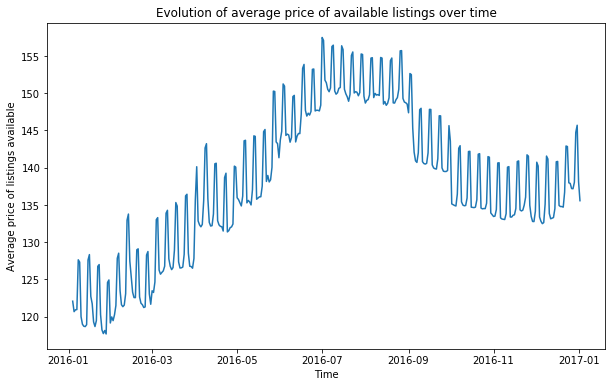

In [702]:
## Look at the average price

def plot_avg_price(data, xaxis, yaxis, title, xlabel, ylabel):

    listings_avg_price_per_day = data.groupby(xaxis).mean()[yaxis].reset_index()
    listings_avg_price_per_day.columns = [xaxis,yaxis]
    x_price = listings_avg_price_per_day[xaxis]
    y_price = listings_avg_price_per_day[yaxis]
    plt.figure(figsize=(10,6))
    plt.plot(x_price,y_price)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
plot_avg_price(calendar_clean, 'date_available', 'price', 'Evolution of average price of available listings over time'
                 , 'Time', 'Average price of listings available')

We can make a few quick observations from this graph:
1. We can see two drastic drops in the number of listings available in April and July. The both corresponds to peaks in the average price of the listings. Moreover, after July's peak in average prices, the price have never been as high ever since during the year.
2. While the number of listings available kept on steadily increasing as of July, the average prices trend have been going down, with a slight increase towards the end of the year, corresponding to the end of the year celebrations.
3. It looks like there is a strong seasonality pattern in the average prices evolution over time.

Let's look at three periods in particular, to understand the data more in details
1. May 2016
2. September 2016
3. December 2016
We have deliberately chosen not to look before May given that the number of listings available varies a lot during that period.

In [703]:
# May 2016
calendar_may_16 = calendar_clean[calendar_clean['date_available'] >= '2016-05-01'][calendar_clean['date_available'] < '2016-06-01']

C:\Users\jtrinco\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


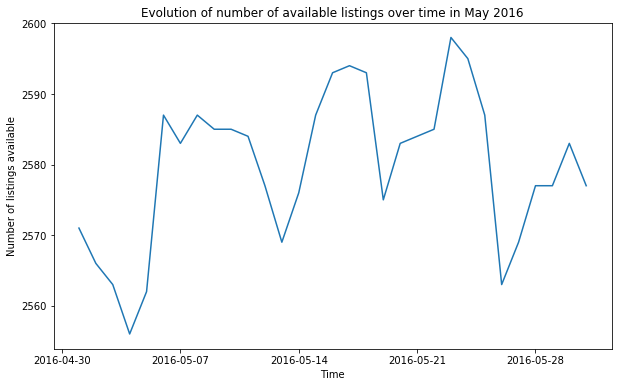

In [704]:
plot_nb_listings(calendar_may_16, 'date_available', 'nb_listings'
                 , 'Evolution of number of available listings over time in May 2016'
                 , 'Time', 'Number of listings available')

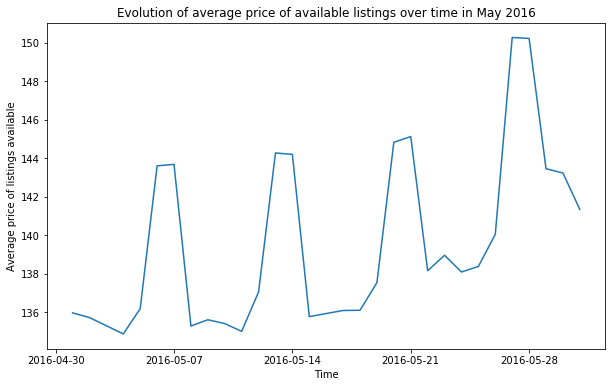

In [705]:
plot_avg_price(calendar_may_16, 'date_available', 'price'
                 , 'Evolution of average price of available listings over time in May 2016'
                 , 'Time', 'Average price of listings available')

In [706]:
# September 2016
calendar_sept_16 = calendar_clean[calendar_clean['date_available'] >= '2016-09-01'][calendar_clean['date_available'] < '2016-10-01']

C:\Users\jtrinco\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


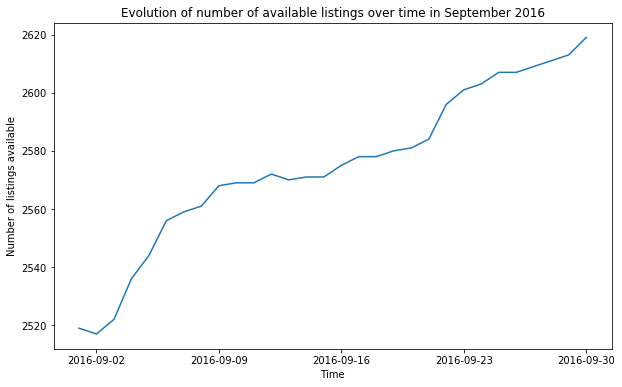

In [707]:
plot_nb_listings(calendar_sept_16, 'date_available', 'nb_listings'
                 , 'Evolution of number of available listings over time in September 2016'
                 , 'Time', 'Number of listings available')

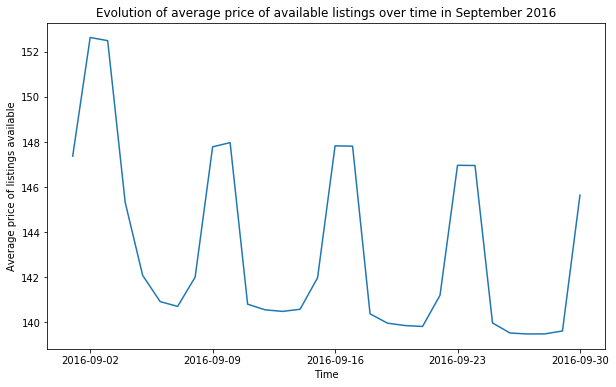

In [708]:
plot_avg_price(calendar_sept_16, 'date_available', 'price'
                 , 'Evolution of average price of available listings over time in September 2016'
                 , 'Time', 'Average price of listings available')

In [709]:
# December 2016
calendar_dec_16 = calendar_clean[calendar_clean['date_available'] >= '2016-12-01'][calendar_clean['date_available'] < '2017-01-01']

C:\Users\jtrinco\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


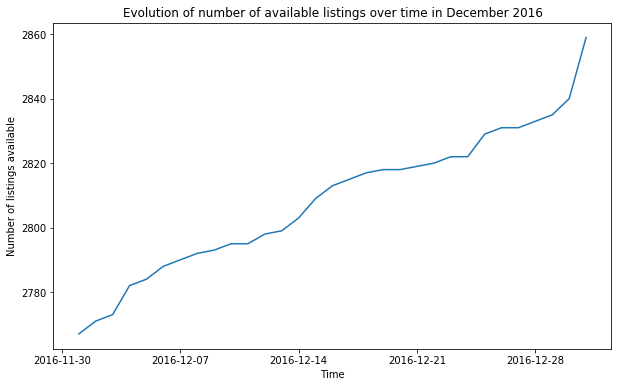

In [710]:
plot_nb_listings(calendar_dec_16, 'date_available', 'nb_listings'
                 , 'Evolution of number of available listings over time in December 2016'
                 , 'Time', 'Number of listings available')

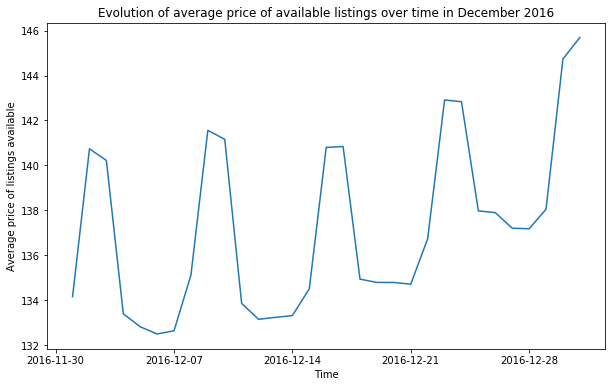

In [711]:
plot_avg_price(calendar_dec_16, 'date_available', 'price'
                 , 'Evolution of average price of available listings over time in December 2016'
                 , 'Time', 'Average price of listings available')

Here are a few quick observations we can derive from these three periods:
1. We can see that the average prices are systematically higher on Fridays and Saturdays.
2. In September and December, the number of listings available do not change on weekends. However, the number of listings available towards the end of December is increasing. This makes us think of people going to their families during the holidays and puttin their place for rent on Airbnb.
